# Setup

In [1]:
import sys
# Python 3.7 is required
assert sys.version_info >= (3,7)

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt #To show color based segmentation and plot some histogram as well

# These libraries provide the functionalities you need for the plot.
from mpl_toolkits.mplot3d import Axes3D #To plot the 3D
#from matplotlib import cm #This one is actually not needed
from matplotlib import colors

# Make sure that optimization is enabled
if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

# Functions

In [2]:
#kernel_blur = np.ones((3, 3), dtype = np.float32)/9
#kernel = np.zeros((3, 3), dtype = np.float32)
#kernel[1, 1] = 1
#sharpen_kernel = 2*kernel - kernel_blur

def hsv_blur(img):
    """This function is to process the img from BGR2HSV 
    and then blur it using Gaussian"""
    
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    img_hsv = cv.GaussianBlur(img_hsv, (5, 5), 0)
    
    return img_hsv

In [3]:
def segmentation(img, img_hsv):
    """This function is to perform the color space segmentation"""
    
    low_red_hsv = (0, 70, 50)
    high_red_hsv = (10, 255, 255)
    
    low_red_light = (170, 70, 50)
    high_red_light = (180, 255, 255)

    low_blue = (100,150,0)
    high_blue = (120,255,255)

    low_yellow = (20, 100, 100)
    high_yellow = (30, 255, 255)

    low_orange = (0, 100, 45)
    high_orange = (225, 250, 255)

    low_black = (0,0,0)
    high_black=(360,255,50)
    
    mask_orange = cv.inRange(img_hsv, low_orange, high_orange)
    mask_black = cv.inRange(img_hsv, low_black, high_black)
    mask_yellow = cv.inRange(img_hsv, low_yellow, high_yellow)
    mask_blue = cv.inRange(img_hsv, low_blue, high_blue)
    mask_red = cv.inRange(img_hsv, low_red_hsv, high_red_hsv)
    mask_red_light = cv.inRange(img_hsv, low_red_light, high_red_light)
    
    mask = mask_red | mask_red_light | mask_blue | mask_yellow | mask_black | mask_orange
    #mask = cv.inRange(img_hsv, low_blue, high_blue)
    
    res = cv.bitwise_and(img, img, mask = mask)
    result = cv.cvtColor(res, cv.COLOR_BGR2RGB)

    struc_ele = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    closing = cv.morphologyEx(mask, cv.MORPH_CLOSE, struc_ele, iterations = 3)
    
    return result, closing

In [4]:
def flood_fill(closing):
    """This function is to fill up the missing pieces inside the mask"""
    
    closing_8u = np.uint8(closing)
    im_fill = closing_8u.copy()

    h, w = im_fill.shape[:2]
    masking = np.zeros((h+2, w+2), dtype = np.uint8)

    #flood fill operation
    cv.floodFill(im_fill, masking, (0, 0), 255)

    #invert the flood fill output
    im_fill_inv = cv.bitwise_not(im_fill)

    mask = closing_8u | im_fill_inv
    
    return mask

In [5]:
def draw_contour_bounding_box(mask, result):
    """This function is to find out the traffic sign contour and draw a bounding box"""
    
    # Find the contours on the inverted binary image, and store them in a list
    # Contours are drawn around white blobs.
    # hierarchy variable contains info on the relationship between the contours
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    new_result = cv.cvtColor(result, cv.COLOR_RGB2BGR)
    new_result_copy = new_result.copy()
    
    # Draw the contours (in red) on the original image and display the result
    # Input color code is in BGR (blue, green, red) format
    # -1 means to draw all contours
    with_contours = cv.drawContours(new_result_copy, contours, -1,(0, 255, 0),1)
    
    x = ((len(contours)) - 1)
    
    # Draw just the first contour
    # The 0 means to draw the first contour
    first_contour = cv.drawContours(new_result, contours, x , (0, 255, 0), 1)
    
    # Draw a bounding box around the first contour
    # x is the starting x coordinate of the bounding box
    # y is the starting y coordinate of the bounding box
    # w is the width of the bounding box
    # h is the height of the bounding box
    x, y, w, h = cv.boundingRect(contours[x])
    cv.rectangle(first_contour,(x,y), (x+w,y+h), (0, 255, 0), 1)
    
    #return x, y, w, h for confusion matrix calculation use
    return first_contour, x, y, w, h

In [6]:
def confusion_matrix(img_width, img_height, s_x1, s_x2, s_y1, s_y2, g_x1, g_x2, g_y1, g_y2):
    """This function is used to calculate the accuracy, recall and etc..."""
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(0, img_width):
        for j in range(0, img_height):
            seg = False
            ground = False
            
            for k in range(s_x1, s_x2):
                for l in range(s_y1, s_y2):
                    if (k==i and l==j):
                        seg = True
                        break
                        
            for k in range(g_x1, g_x2):
                for l in range(g_y1, g_y2):
                    if (k==i and l==j):
                        ground = True
                        break
                        
            if (seg==True and ground==True):
                TP = TP + 1
            if (seg==False and ground==False):
                TN = TN + 1
            if (seg==True and ground==False):
                FP = FP + 1
            if (seg==False and ground==True):
                FN = FN + 1
    
    #Calculate accuracy
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
    #Calculate IOU (area of overlap/area of union = TP/(TP+FP+FN)
    IOU = TP/(TP+FP+FN)
    
    #Calculate Precision
    precision = TP/(TP+FP)
    
    #Calculate Recall
    recall = TP/(TP+FN)
    
    #Calculate F-Score
    F_score = (2*precision*recall)/(precision+recall)
            
    return accuracy, IOU, precision, recall, F_score

# Start

## Read annotation file

In [7]:
#Read the annotation file to get the images' name and ground truth
annotation = open('Annotation.txt', 'r')
lines = annotation.readlines()
sample_data = []
count = 0 #To count how many images have been loaded

for i in lines:
    x = i.split(";")
    sample_data.append(x)
    count += 1

## Determine the annotation values

In [8]:
print(sample_data[0][0]) #Image name
print(sample_data[0][1]) #Image height
print(sample_data[0][2]) #Image width
print(sample_data[0][3]) #Ground Truth y1
print(sample_data[0][4]) #Ground Truth x1
print(sample_data[0][5]) #Ground Truth y2
print(sample_data[0][6]) #Ground Truth x2
print(sample_data[0][7]) #Not Gonna Use

000_0001.png
134
128
19
7
120
117
0


# Perform Segmentation


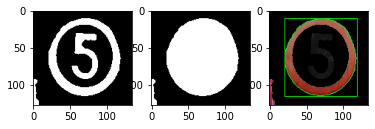

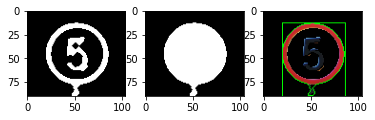

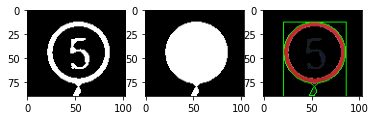

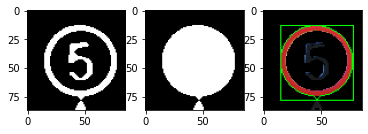

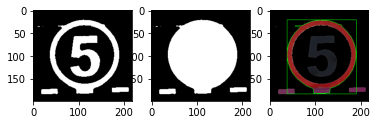

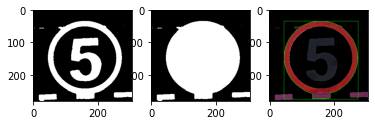

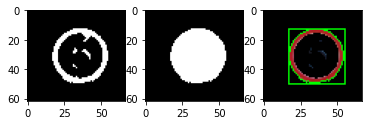

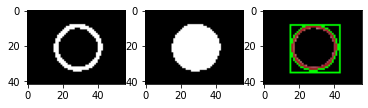

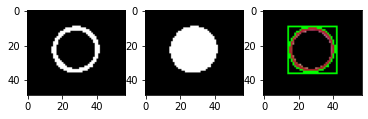

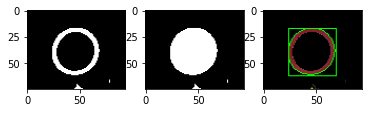

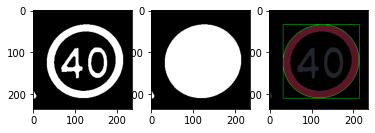

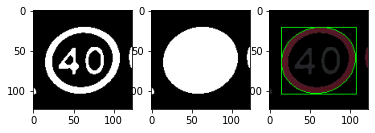

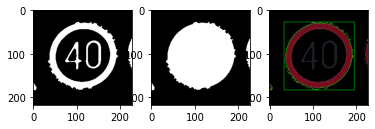

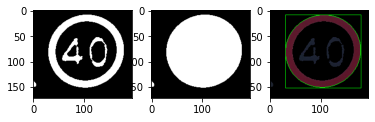

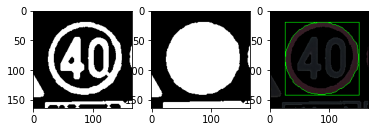

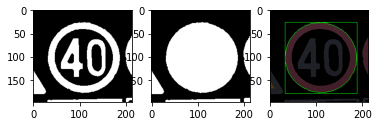

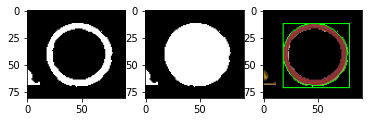

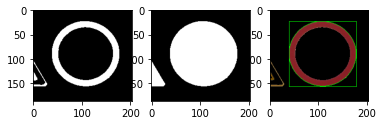

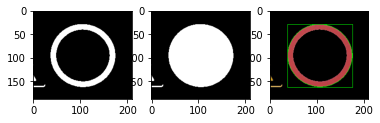

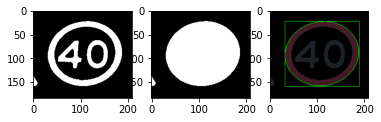

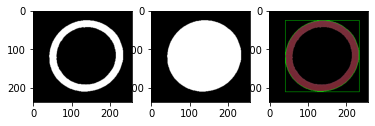

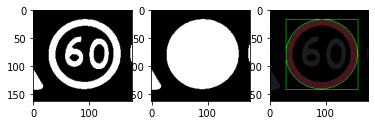

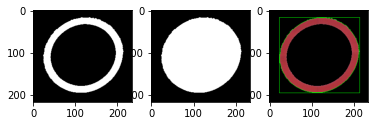

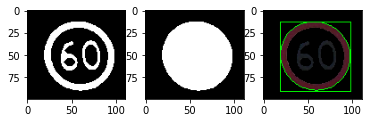

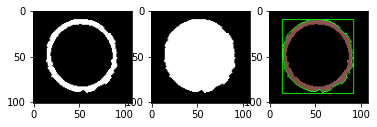

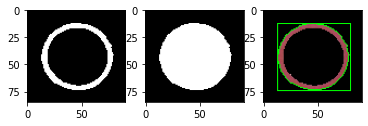

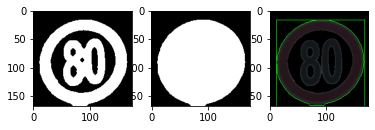

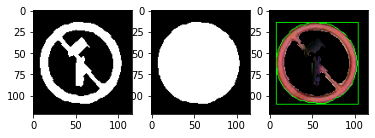

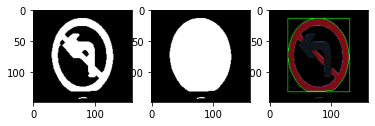

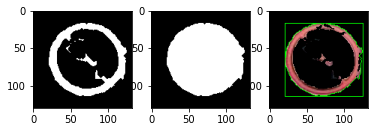

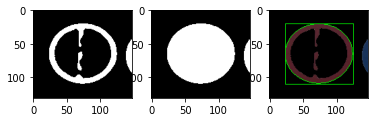

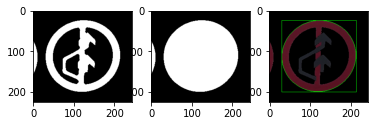

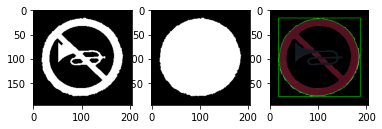

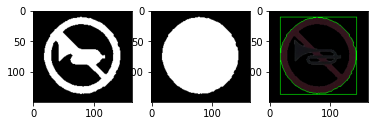

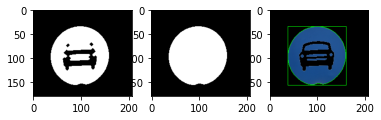

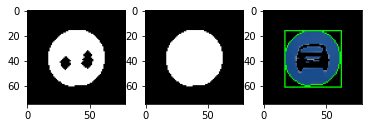

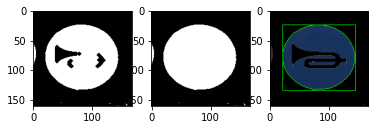

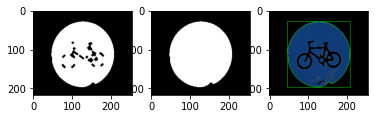

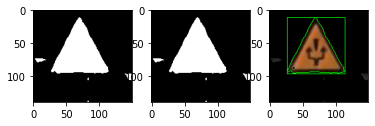

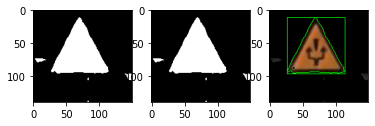

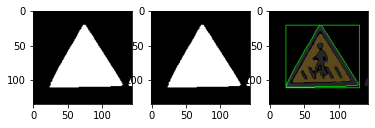

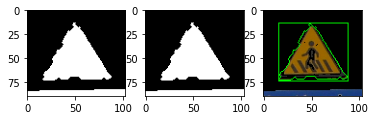

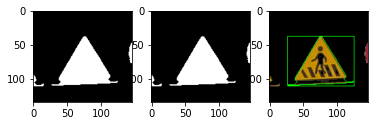

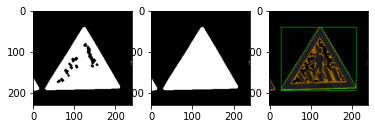

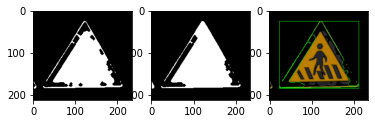

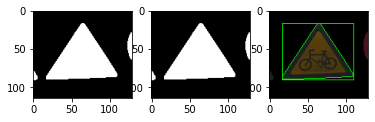

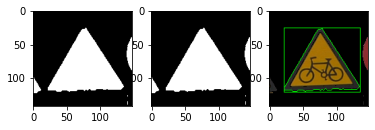

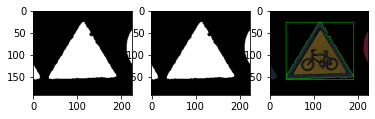

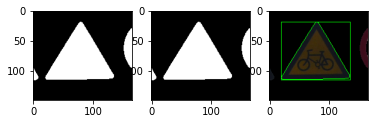

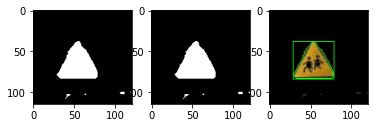

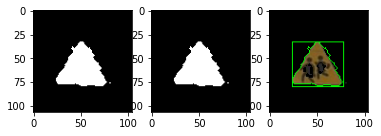

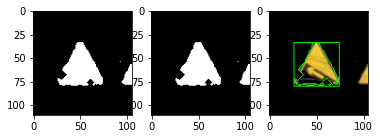

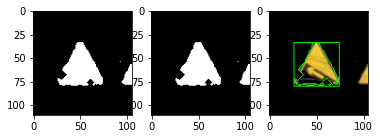

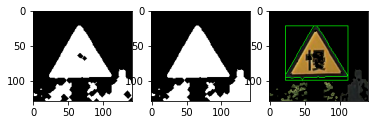

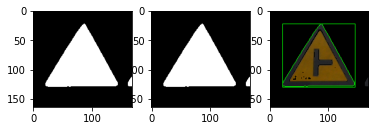

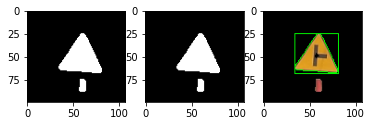

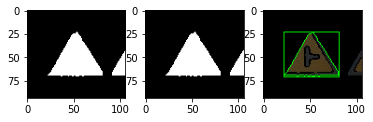

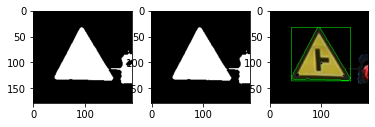

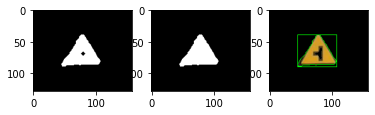

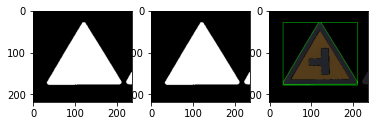

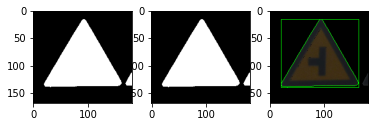

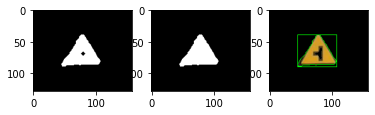

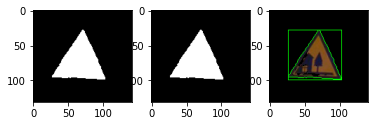

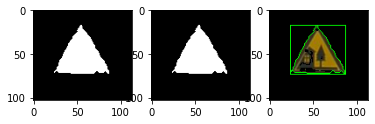

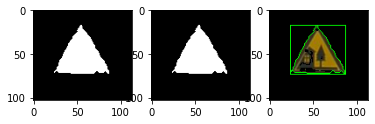

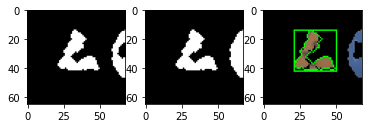

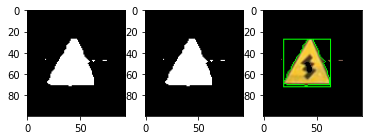

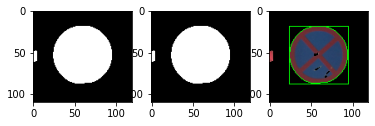

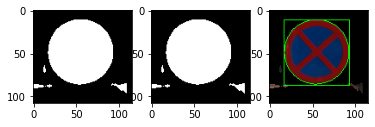

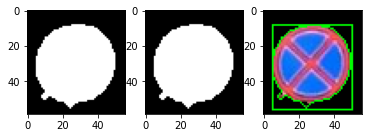

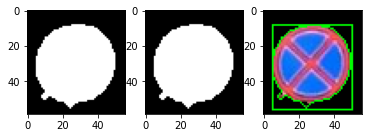

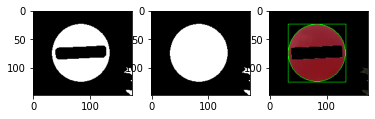

In [9]:
predict_x1 = []
predict_x2 = []
predict_y1 = []
predict_y2 = []

for i in range(count-1):
    x = 0
    y = 0
    w = 0
    h = 0
    
    #Get the image name
    img_name = sample_data[i][0]
    img = cv.imread(img_name)
    
    #Perform BGR2HSV & Gaussian Blur
    img_hsv = hsv_blur(img)
    
    #Perform Color Space Segmentation
    result, closing = segmentation(img, img_hsv)
    
    #Perform flood fill to the mask
    mask = flood_fill(closing)
    
    #Draw the contour and bounding box
    bounding_box, x, y, w, h = draw_contour_bounding_box(mask, result)
    
    predict_x1.append(y)
    predict_x2.append(y+h)
    predict_y1.append(x)
    predict_y2.append(x+h)
    
    bounding_box_rgb = cv.cvtColor(bounding_box, cv.COLOR_BGR2RGB)
    plt.subplot(1,3,1)
    plt.imshow(closing, cmap = 'gray')
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap = 'gray')
    plt.subplot(1,3,3)
    plt.imshow(bounding_box_rgb)
    plt.show()

# Calculate Confusion Matrix and Result:

In [10]:
Total_accuracy = []
Total_IOU = []
Total_precision = []
Total_recall = []
Total_F_score = []

for i in range(count-1):
    #Get the image name
    img_name = sample_data[i][0]
    img = cv.imread(img_name)
    
    #Calculate the confusion matrix
    width, height = img.shape[:2]
    ground_x1 = int(sample_data[i][4])
    ground_x2 = int(sample_data[i][6])
    ground_y1 = int(sample_data[i][3])
    ground_y2 = int(sample_data[i][5])
    accuracy, IOU, precision, recall, F_score = confusion_matrix(width, height, predict_x1[i], predict_x2[i], predict_y1[i], predict_y2[i], ground_x1, ground_x2, ground_y1, ground_y2)
    
    Total_accuracy.append(accuracy)
    Total_IOU.append(IOU)
    Total_precision.append(precision)
    Total_recall.append(recall)
    Total_F_score.append(F_score)

    print("IMG:\t\t", sample_data[i][0])
    print("Accuracy:\t", accuracy)
    print("IOU:\t\t", IOU)
    print("Precision:\t", precision)
    print("Recall:\t\t", recall)
    print("F-Score:\t", F_score)
    print("")
    
print("Done.")

IMG:		 000_0001.png
Accuracy:	 0.9215834888059702
IOU:		 0.8854344122657581
Precision:	 0.9428571428571428
Recall:		 0.9356435643564357
F-Score:	 0.9392365032753557

IMG:		 000_1_0020.png
Accuracy:	 0.8110042735042735
IOU:		 0.7048715382048716
Precision:	 0.7125990892224658
Recall:		 0.9848484848484849
F-Score:	 0.8268910852333887

IMG:		 000_1_0022.png
Accuracy:	 0.8087378640776699
IOU:		 0.7106723237597912
Precision:	 0.7345252150446956
Recall:		 0.9563021519543259
F-Score:	 0.8308690260421635

IMG:		 000_1_0025.png
Accuracy:	 0.9573643410852714
IOU:		 0.9266835210296483
Precision:	 0.954319526627219
Recall:		 0.9696969696969697
F-Score:	 0.9619467970893474

IMG:		 000_1_0044.png
Accuracy:	 0.9272630433272353
IOU:		 0.8810001894298163
Precision:	 0.8860691967687853
Recall:		 0.9935483870967742
F-Score:	 0.9367358859191525

IMG:		 000_1_0045.png
Accuracy:	 0.9104667871876884
IOU:		 0.870605771324256
Precision:	 0.8876272112560617
Recall:		 0.978448275862069
F-Score:	 0.930827633133975

IMG:		 042_1_0004_1_j.png
Accuracy:	 0.9449667381384353
IOU:		 0.8539325842696629
Precision:	 0.987012987012987
Recall:		 0.8636363636363636
F-Score:	 0.9212121212121213

IMG:		 043_1_0039.png
Accuracy:	 0.894671893147503
IOU:		 0.7977841265417044
Precision:	 1.0
Recall:		 0.7977841265417044
F-Score:	 0.8875193798449613

IMG:		 043_0002.png
Accuracy:	 0.8520721231001605
IOU:		 0.5412763466042154
Precision:	 1.0
Recall:		 0.5412763466042154
F-Score:	 0.7023741690408357

IMG:		 043_0014.png
Accuracy:	 0.8412284223203532
IOU:		 0.5928975810602162
Precision:	 1.0
Recall:		 0.5928975810602162
F-Score:	 0.744426494345719

IMG:		 043_0035_j.png
Accuracy:	 0.9506566439498084
IOU:		 0.8628009108653221
Precision:	 1.0
Recall:		 0.8628009108653221
F-Score:	 0.9263479589609256

IMG:		 044_1_0013_1_j.png
Accuracy:	 0.8677233002518145
IOU:		 0.49261363636363636
Precision:	 1.0
Recall:		 0.49261363636363636
F-Score:	 0.6600685192234488

IMG:		 044_1_0014.png
Accuracy:	 0.9120082413310527
IOU:		 0.831

# Final Results:

In [11]:
print("Final Results:")
print("Accuracy:\t", sum(Total_accuracy)/count)
print("IOU:\t\t", sum(Total_IOU)/count)
print("Precision:\t", sum(Total_precision)/count)
print("Recall:\t\t", sum(Total_recall)/count)
print("F-Score:\t", sum(Total_F_score)/count)

Final Results:
Accuracy:	 0.9075513270985923
IOU:		 0.8129736437916868
Precision:	 0.9656022822913504
Recall:		 0.8322978362265134
F-Score:	 0.8852950914431734
